In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#https://analyticsindiamag.com/a-comparison-of-4-popular-transfer-learning-models/
#https://keras.io/api/applications/efficientnet/ 
#https://vigneshgig.medium.com/xception-neural-network-transfer-learning-and-data-processing-using-ai-c3e7a4ea7bf2 

In [3]:
pip install split-folders tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow as tf
import numpy as np
import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = '/content/drive/MyDrive/rice_images'

Split Dataset into 3 part: Train, Val, and Test

In [18]:
splitfolders.ratio(
    base_dir,
    output='Capstone',
    ratio=(.6, 0.2,0.2)
)

Copying files: 2171 files [00:05, 395.13 files/s]


In [19]:
train_dir = 'Capstone/train'
val_dir = 'Capstone/val' 
test_dir = 'Capstone/test'

class_name = os.listdir(train_dir)

In [20]:
class_name 

['BrownSpot', 'LeafBlast', 'Hispa', 'Healthy']

Data Augmentation

In [24]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=(0.2), 
                    horizontal_flip=True,
                    )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150,150), 
    batch_size=32, 
    shuffle=True,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

Found 1518 images belonging to 4 classes.
Found 433 images belonging to 4 classes.
Found 439 images belonging to 4 classes.


Modeling

In [26]:
from keras.callbacks import EarlyStopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=3)

In [27]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

In [28]:
from tensorflow.keras.applications import Xception
tfmodel = Xception(weights='imagenet', 
                                include_top=False, 
                                input_shape=(150,150,3))

In [29]:
from keras.models import Sequential
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D

In [30]:
model = Sequential()
model.add(tfmodel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))      
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [32]:
history = model.fit(train_generator,
                    epochs=50,
                    callbacks=[monitor_val_acc,reduce_lr],
                    validation_data=validation_generator)

Epoch 1/50
48/48 [==============================] - 21s 340ms/step - loss: 1.3874 - accuracy: 0.2846 - val_loss: 1.3392 - val_accuracy: 0.3603 - lr: 1.0000e-04
Epoch 2/50
48/48 [==============================] - 14s 291ms/step - loss: 1.2846 - accuracy: 0.3794 - val_loss: 1.2672 - val_accuracy: 0.4480 - lr: 1.0000e-04
Epoch 3/50
48/48 [==============================] - 14s 296ms/step - loss: 1.1984 - accuracy: 0.4084 - val_loss: 1.1460 - val_accuracy: 0.5196 - lr: 1.0000e-04
Epoch 4/50
48/48 [==============================] - 14s 294ms/step - loss: 1.0936 - accuracy: 0.4881 - val_loss: 1.0639 - val_accuracy: 0.5820 - lr: 1.0000e-04
Epoch 5/50
48/48 [==============================] - 15s 301ms/step - loss: 0.9978 - accuracy: 0.5810 - val_loss: 0.8964 - val_accuracy: 0.6236 - lr: 1.0000e-04
Epoch 6/50
48/48 [==============================] - 14s 288ms/step - loss: 0.8660 - accuracy: 0.6542 - val_loss: 0.7975 - val_accuracy: 0.7067 - lr: 1.0000e-04
Epoch 7/50
48/48 [======================

In [33]:
model.save("Model.h5")

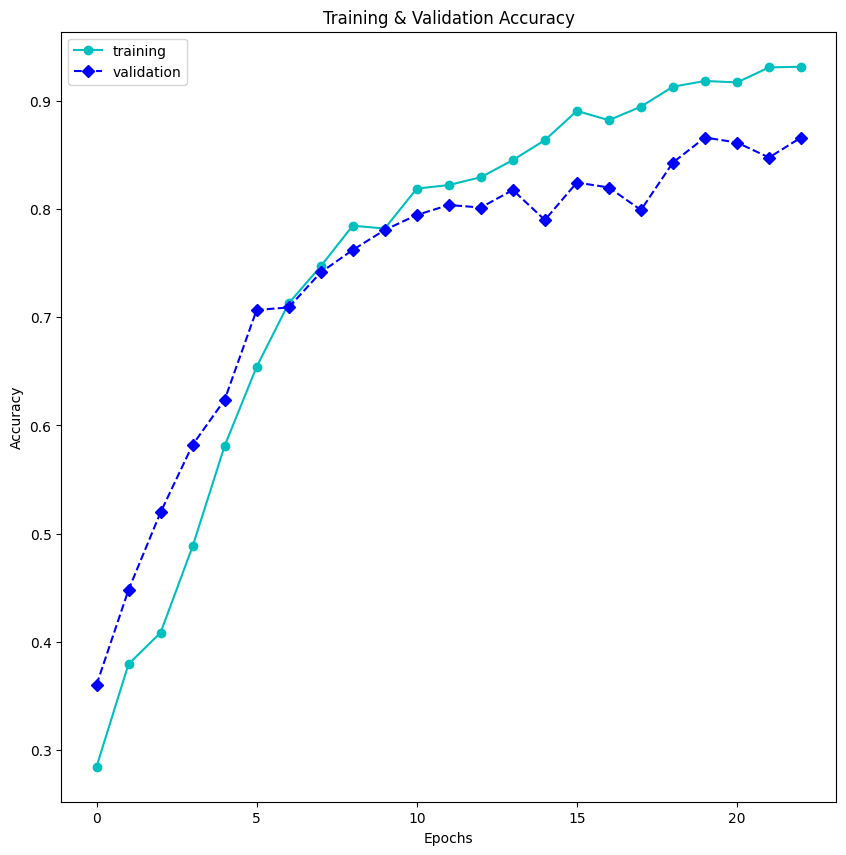

In [34]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['accuracy'])), 
         history.history['accuracy'],
         'co-',
         label='training')
plt.plot(range(len(history.history['val_accuracy'])), 
         history.history['val_accuracy'],
         'bD--',
         label='validation')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

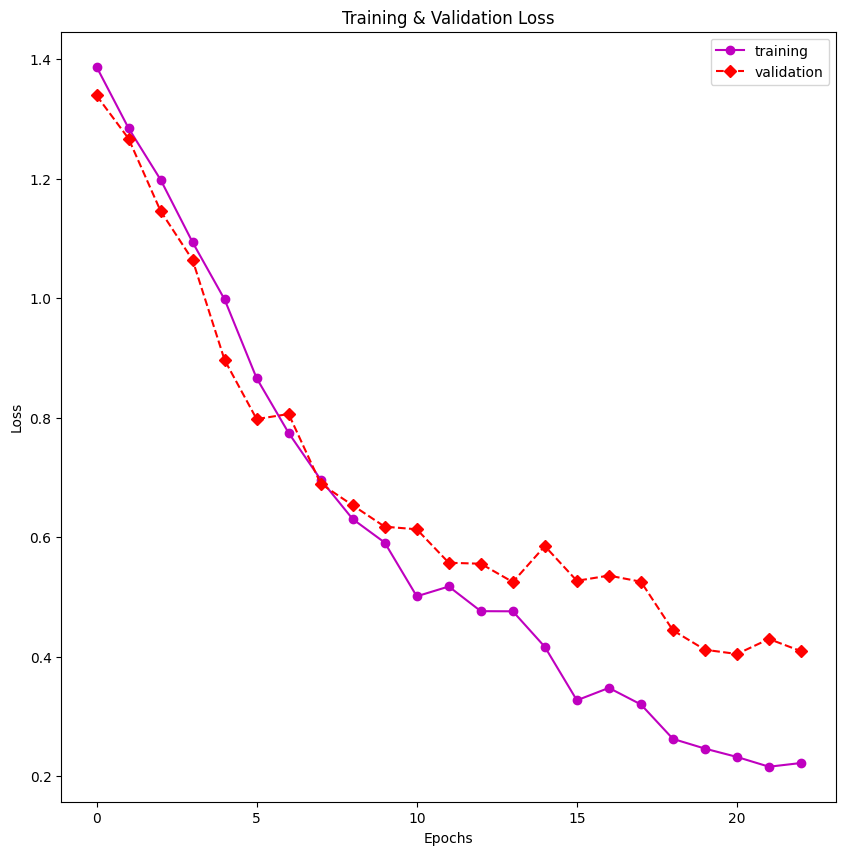

In [35]:
plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['loss'])), 
         history.history['loss'],
         'mo-',
         label='training')
plt.plot(range(len(history.history['val_loss'])), 
         history.history['val_loss'],
         'rD--',
         label='validation')
plt.title('Training & Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [38]:
test_evaluate = model.evaluate(test_generator)

print(f'Test loss     : {test_evaluate[0]}')
print(f'Test accuracy : {round(test_evaluate[1],2)}')

14/14 [==============================] - 1s 71ms/step - loss: 0.7861 - accuracy: 0.7585
Test loss     : 0.7861270308494568
Test accuracy : 0.76


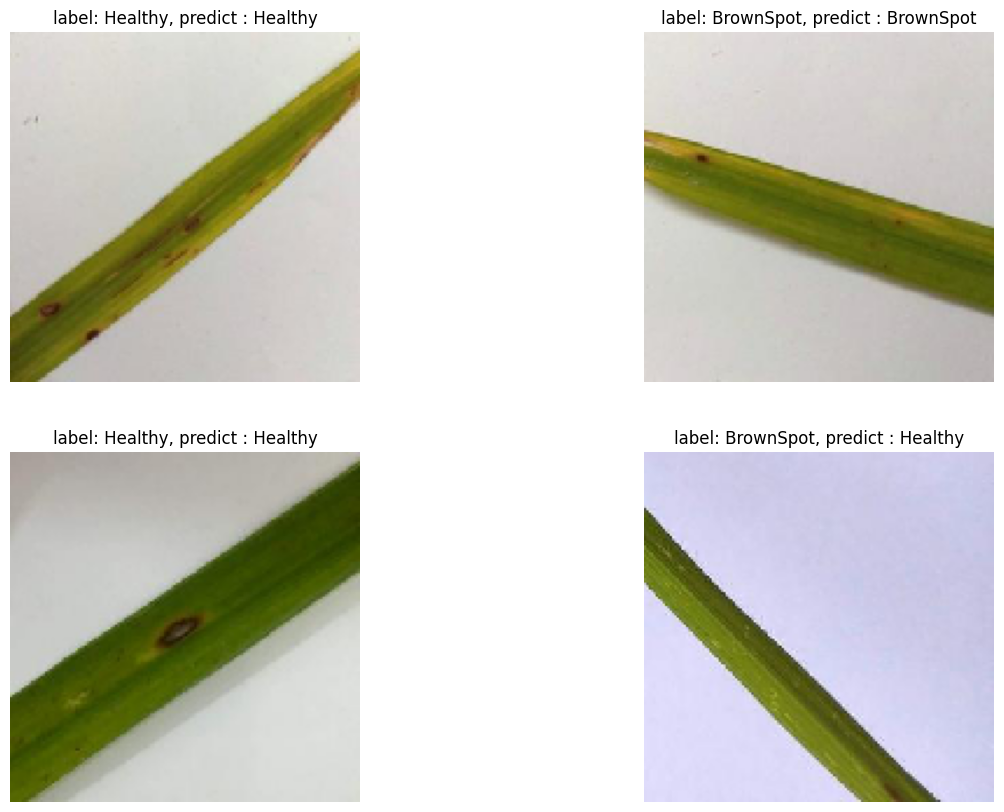

In [37]:
image ,label = next(iter(test_generator))

plt.figure(figsize=(15,10))
for i in range(4) :
    TrueLabel = class_name[np.argmax(label[i])]
    plt.subplot(2,2,i+1)
    plt.axis('off')
    y_pred = np.argmax(model.predict(image[i][None,...],verbose=0))
    plt.imshow(tf.squeeze(image[i]))
    plt.title(f'label: {TrueLabel}, predict : {class_name[y_pred]}')